In [1]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-06 20:32:57.996654: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# load a case (its segmentation and strain)

In [2]:
# load a case:
patient_id = 'ID_0015'
# first: get the ED and ES frame
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
patient_id_num = ff.ID_00XX_to_XX(patient_id)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED[M_ED==1] = 3
M_nifti_ED = nb.Nifti1Image(M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES[M_ES==1] = 3
M_nifti_ES = nb.Nifti1Image(M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)


# fourth: prepare input and resample to 1.25mm x 1.25mm x 8mm
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))

V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)


# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)

V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))

# fifth: predict motion vector
y_t = nb.load(os.path.join(main_path, 'models/fine_tune_carmen/ID_0015/mvf.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

# last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]



y_t shape:  (1, 128, 128, 16, 3)


In [3]:
# calculate strain
strain = myocardial_strain_zc.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)
strain_es = myocardial_strain_zc.MyocardialStrain(mask=mask_end_systole, flow=y_t[0,:,:,:,:])
strain_es.calculate_strain(lv_label=2)

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())

Radial strain:  10.861956049808054
Circumferential strain:  -12.970062596101187


# Step 1: define the RV insertion point

(128, 128, 16) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(128, 128, 16) [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
6
apex
phi_angle:  125.20061417029123


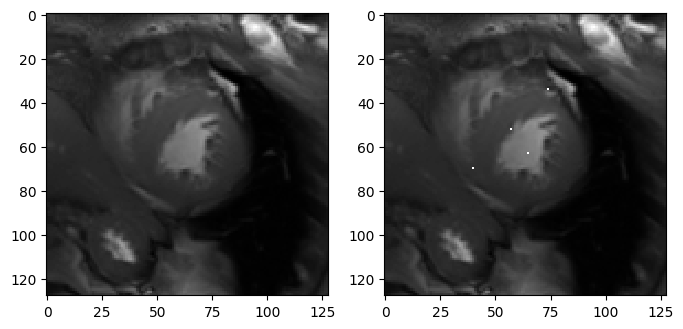

In [5]:
V_ed = V[:,:,:,0]

# define mid slice
# find the nonzero slices in the strain.mask
slice_nonzero_ed = [i for i in range(strain.mask.shape[2]) if np.sum(strain.mask[:,:,i])>0]
slice_nonzero_es = [i for i in range(strain_es.mask.shape[2]) if np.sum(strain_es.mask[:,:,i])>0]
# middle_slice
mid_slice = slice_nonzero_ed[len(slice_nonzero_ed)//2]
print(strain.mask.shape, slice_nonzero_ed)
print(strain_es.mask.shape, slice_nonzero_es)
print(mid_slice)

# find out it starts from apex or base
start_slice = strain.mask[:,:,slice_nonzero_ed[0]]; start_slice[start_slice >0] = 1
end_slice = strain.mask[:,:,slice_nonzero_ed[-1]]; end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start = 'apex'
else:
    start = 'base'
print(start)

# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(V_ed[:,:,mid_slice], cmap='gray')
# from the figure, we define the RV insertion points
ii = np.copy(V_ed[:,:,mid_slice])
insertion_p1 = [34,74]
insertion_p2 = [70,40]
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


In [ ]:
# rotate the data so that RV is under LV
polar = myocardial_strain_zc.PolarMap(strain.Err, strain.Ecc,strain.mask, insertion_p1, insertion_p2, non_slice_num = )